# Understanding and Preventing Collapse in Self-Supervised Learning A Deep Dive into BYOL
> Bootstrap your own latents.

- toc: true
- badges: true
- comments: true
- sticky_rank: 2
- author: Abhishek Sharma
- image: images/byol.png
- categories: [self-supervised-learning, math, deeplearning, fast.ai]

## Introduction

Why do machine learning models typically need labeled data to learn? The core challenge in self-supervised learning is to extract meaningful representations without explicit labels. Instead of relying on labeled datasets, can we learn representations simply by understanding relationships between examples?

Imagine teaching someone to distinguish between cats and dogs, but instead of providing explicit labels, you only tell them whether two animals belong to the same or different categories. Could they eventually learn the distinction? This thought experiment highlights a key insight: understanding relationships can sometimes be sufficient for learning meaningful representations.

BYOL (Bootstrap Your Own Latent) is a self-supervised learning framework that leverages this idea. Unlike earlier contrastive methods that rely on negative pairs, BYOL innovates by learning without explicit dissimilarity constraints. How does it avoid collapse while training with only positive pairs? Let’s dive into the details.

---

## 1. Traditional Supervised vs. Self-Supervised Learning

### 1.1 Supervised Learning (ImageNet Pre-training)
- Requires millions of labeled images
- Each image is categorized into one of 1000 classes
- Learns features through explicit supervision (e.g., "this is a dog")

### 1.2 Self-Supervised Learning (BYOL Approach)
- Uses unlabeled images
- No need for human categorization
- Learns features by understanding relationships between images

**Thought Experiment:** Imagine you have:
1. **1 million labeled images** (supervised approach)
2. **100 million unlabeled images** (self-supervised approach)

Could self-supervised learning from a larger unlabeled dataset provide better or different kinds of features compared to supervised learning from fewer labeled examples?


---

## 2. How BYOL Works: Learning Without Negative Pairs

Unlike earlier contrastive methods (e.g., SimCLR), BYOL does not require negative pairs. Instead, it relies on two key mechanisms:
1. **Data Augmentation to Create Positive Pairs:**
    - Given an image, two augmented views are created (e.g., cropping, color jittering, rotation).
    - The model learns to predict one view from the other.
2. **Asymmetric Network Design:**
    - An online network and a target network work together.
    - The online network learns directly through gradient updates, while the target network updates slowly via an exponential moving average (EMA).

### 2.1 Architectural Components of BYOL
1. **Online Network:**
    - Encoder: $f_\theta$
    - Projector: $g_\theta$
    - Predictor: $q_\theta$
2. **Target Network:**
    - Encoder: $f_\xi$
    - Projector: $g_\xi$ (EMA of online parameters)

### 2.2 Loss Function
The BYOL loss is:
$$
L_{\text{BYOL}} = \mathbb{E}\left[\|q_\theta(g_\theta(f_\theta(x))) - g_\xi(f_\xi(x^+))\|^2\right]
$$
Unlike contrastive loss, it does not rely on negative pairs.

---

## 3. Avoiding Collapse: The Role of Asymmetry

### 3.1 Representation Collapse in SSL
Collapse occurs when a model maps all inputs to the same representation, leading to trivial solutions:
1. **Constant Representations:**
    
    ∃𝑐∈ℝ𝑑 s.t. 𝔼𝑥[|𝑓𝜃(𝑥)−𝑐|2]≈0

2. **Dimensionality Collapse:** Representations lie in a low-dimensional subspace.

### 3.2 How BYOL Avoids Collapse

BYOL prevents collapse through two mechanisms:

1. **Predictor Asymmetry:**
    
    - The predictor 𝑞𝜃 ensures that the representations do not collapse.
    - The loss function minimizes:
    
    min𝜃‖𝑞𝜃(𝑧𝜃)−𝑧′𝜉‖2
    

2. **EMA Dynamics:**
    - The target network updates via:
      𝜉←𝜏𝜉+(1−𝜏)𝜃
    - This creates a slowly evolving target that prevents trivial solutions.

---

## 4. Mathematical Insights

### 4.1 Conditional Variance Perspective
BYOL minimizes:
$$
\mathbb{E}[\text{Var}(z'_\xi | z_\theta)]
$$
Using the law of total variance:
$$
\text{Var}(z'_\xi) = \mathbb{E}[\text{Var}(z'_\xi|z_\theta)] + \text{Var}(\mathbb{E}[z'_\xi|z_\theta])
$$
BYOL prevents collapse by balancing these terms.

### 4.2 Stability Analysis
BYOL’s predictor introduces an implicit regularization:
$$
\min_\theta \|q_\theta(z_\theta) - z'_\xi\|^2 \quad \text{s.t. } z_\theta = f_\theta(x), z'_\xi = \text{EMA}(f_\theta(x))
$$


---

## 5. Empirical Insights and Practical Considerations

### 5.1 Detecting Collapse
1. **Feature Variance:**
    $$
    \text{Var}(z_\theta) = \frac{1}{d}\sum_{i=1}^d \text{Var}(z_\theta^{(i)})
    $$
2. **Eigenvalue Spectrum:** Collapse occurs when:
    $$
    \frac{\lambda_{\max}(C)}{\lambda_{\min}(C)} > 10^3
    $$

### 5.2 Recommended Hyperparameters
- **EMA Momentum:** Warm up $\tau$ from 0.996 to 0.999 over 1000 steps.
- **Predictor Learning Rate:** Should be **10× encoder LR**.
- **Augmentations:** Strong augmentations remain crucial.


---

## 6. Key Takeaways

1. **BYOL learns representations without negative pairs** by leveraging moving target networks.
2. **Architectural asymmetry** is crucial in preventing collapse.
3. **The predictor network acts as an implicit constraint**, ensuring diverse representations.
4. **The exponential moving average (EMA) smooths updates**, maintaining stable learning dynamics.





---

## 7. Practical Implementation

Let's use fast.ai to implement the paper from scratch using a manageble dataset ( CIFAR10 ) and resnet18 for faster iterations. We can later scale it to larger datasets and models.


```py
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
from fastai.vision.all import *

import albumentations as A
from albumentations.pytorch import ToTensorV2


class BYOL(nn.Module):
    def __init__(self,
                 encoder='resnet18',
                 projection_size=128,
                 projection_hidden=256,
                 prediction_hidden=64):
        super().__init__()
        
        # 1. Online encoder - initialize the model first
        encoder_model = getattr(models, encoder)(weights=None)
        self.online_encoder = nn.Sequential(
            *list(encoder_model.children())[:-1],  # Remove final FC layer
            nn.AdaptiveAvgPool2d((1, 1)),  # Add adaptive pooling
            nn.Flatten()  # Add flatten layer
        )
        
        # Get encoder output dimension
        self.online_encoder.eval()
        with torch.no_grad():
            enc_out = self.online_encoder(torch.randn(4, 3, 32, 32))
            enc_dim = enc_out.shape[1]
            
            self.enc_dim = enc_dim
        
        self.online_encoder.train()
            
        # 2. Projector
        self.online_projector = nn.Sequential(
            nn.Linear(enc_dim, projection_hidden),
            nn.BatchNorm1d(projection_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(projection_hidden, projection_size)
        )
        
        # 3. Predictor
        self.predictor = nn.Sequential(
            nn.Linear(projection_size, prediction_hidden),
            nn.BatchNorm1d(prediction_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(prediction_hidden, projection_size)
        )
        
        # 4. Target network - no gradients needed
        self.target_encoder = None
        self.target_projector = None
        self.init_target_network()

    def init_target_network(self):
        """Initialize target network with online network weights"""
        self.target_encoder = deepcopy(self.online_encoder)
        self.target_projector = deepcopy(self.online_projector)
        
        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x is expected to be a tuple of (view1, view2)
        """
        if isinstance(x, (tuple, list)):
            x1, x2 = x
        else:
            x1, x2 = x, x  # For validation
            
        # Online network forward passes
        z1 = self.online_projector(self.online_encoder(x1))
        z2 = self.online_projector(self.online_encoder(x2))
        
        # Get predictions
        p1 = self.predictor(z1)
        p1 = F.normalize(p1, dim=-1)
        
        p2 = self.predictor(z2)
        p2 = F.normalize(p2, dim=-1)
        
        # Target network forward passes
        with torch.no_grad():
            t1 = self.target_projector(self.target_encoder(x1))
            t2 = self.target_projector(self.target_encoder(x2))
            t1 = F.normalize(t1, dim=-1)
            t2 = F.normalize(t2, dim=-1)
            
        return p1, p2, t1.detach(), t2.detach()
    
    @torch.no_grad()
    def update_target_network(self, tau):
        """
        Update target network parameters using exponential moving average
        tau: EMA decay rate (0,1)
        """
        for online_p, target_p in zip(self.online_encoder.parameters(),
                                    self.target_encoder.parameters()):
            target_p.data = tau * target_p.data + (1 - tau) * online_p.data
            
        for online_p, target_p in zip(self.online_projector.parameters(),
                                    self.target_projector.parameters()):
            target_p.data = tau * target_p.data + (1 - tau) * online_p.data

class BYOLLoss(nn.Module):
    def forward(self, preds, *args):
        """
        Compute BYOL's loss function.
        preds: tuple of (p1, p2, t1, t2) from BYOL model
        """
        p1, p2, t1, t2 = preds
        
        # Symmetric loss
        loss = (
            2 - 2 * F.cosine_similarity(p1, t2.detach(), dim=-1).mean() +
            2 - 2 * F.cosine_similarity(p2, t1.detach(), dim=-1).mean()
        ) / 2
        
        return loss

class BYOLMetrics(Callback):
    def __init__(self, τ_base=0.996):
        super().__init__()
        self.τ_base = τ_base
        self.feat_var = None  # Store feat_var as instance variable
        self.output_similarity = None  # Track output similarity
        
    def before_train(self):
        self.total_steps = len(self.learn.dls.train) * self.learn.n_epoch
        self.current_step = 0
        
    def after_batch(self):
        # Update target network
        τ = 1 - (1 - self.τ_base) * (math.cos(math.pi * self.current_step / self.total_steps) + 1) / 2
        self.learn.model.update_target_network(τ)
        
        # Compute feature variance (collapse detection)
        if not self.training: return
        with torch.no_grad():
            # Handle tuple input - take first view
            x = self.xb[0][0] if isinstance(self.xb[0], tuple) else self.xb[0]
            z = self.learn.model.online_projector(
                self.learn.model.online_encoder(x)
            )
            t = self.learn.model.target_projector(
                self.learn.model.target_encoder(x)
            )
            
            # Compute cosine similarity
            self.output_similarity = F.cosine_similarity(
                z, t, dim=1
            ).mean().item()
            
            self.feat_var = z.var(dim=0).mean().item()
            
            # Check for collapse
            if self.feat_var < 1e-4:
                raise CancelFitException("Training collapsed!")
        
        self.current_step += 1
    
    def after_epoch(self):
        """Log feature variance at the end of each epoch"""
        if self.feat_var is not None:
            print(f"Feature variance: {self.feat_var:.6f}")
            print(f"Output similarity: {self.output_similarity:.6f}")

def get_augmentations():
    """Get BYOL's augmentation pipeline"""
    return A.Compose([
        A.RandomResizedCrop(32, 32),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.2,
            hue=0.1,
            p=0.8
        ),
        A.ToGray(p=0.2),
        A.GaussianBlur(p=0.1),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

class TwoCropsTransform:
    def __init__(self, aug):
        self.aug1 = aug
        self.aug2 = deepcopy(aug)
        
    def __call__(self, x):
        # Convert PILImage/Tensor to numpy array
        if isinstance(x, torch.Tensor):
            img = x.numpy()
        elif isinstance(x, PILImage):
            img = np.array(x)
        else:
            img = x
            
        if img.ndim == 2:  # Handle grayscale
            img = np.repeat(img[..., None], 3, axis=-1)
            
        # Create two views
        view1 = self.aug1(image=img)['image']
        view2 = self.aug2(image=img)['image']
        
        # Convert to NCHW format
        view1 = torch.from_numpy(view1).float().permute(2, 0, 1)  # HWC -> CHW
        view2 = torch.from_numpy(view2).float().permute(2, 0, 1)  # HWC -> CHW
        
        return (
            TensorImage(view1),
            TensorImage(view2)
        )

def get_data(batch_size=256):
    """Setup CIFAR-10 with dual augmentations"""
    path = untar_data(URLs.CIFAR)
    
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),  # One block for each view
        get_items=get_image_files,
        splitter=RandomSplitter(),
        item_tfms=TwoCropsTransform(get_augmentations())
    )
    
    return dblock.dataloaders(
        path,
        bs=batch_size,
        num_workers=4
    )

class FeatureVarianceMetric(Metric):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.total = 0
        self.count = 0
        
    def accumulate(self, learn):
        x = learn.xb[0][0] if isinstance(learn.xb[0], tuple) else learn.xb[0]
        with torch.no_grad():
            z = learn.model.online_projector(learn.model.online_encoder(x))
            var = z.var(dim=0).mean().item()
            
        self.total += var
        self.count += 1
        
    @property
    def value(self):
        return self.total/self.count if self.count != 0 else None
    

dls = get_data()
model = BYOL()


def test_target_network_initialization():
    model = BYOL()
    for t, o in zip(model.target_encoder.parameters(),
                    model.online_encoder.parameters()):
        assert torch.allclose(t, o)
        assert not t.requires_grad

def test_ema_update():
    model = BYOL()
    initial_weight = model.target_encoder[0].weight.clone()
    model.online_encoder[0].weight.data += 0.1
    model.update_target_network(0.9)
    new_weight = model.target_encoder[0].weight
    expected = 0.9 * initial_weight + 0.1 * model.online_encoder[0].weight
    assert torch.allclose(new_weight, expected, atol=1e-6)

def test_normalization():
    model = BYOL()
    x = torch.randn(4, 3, 32, 32)
    p1, p2, t1, t2 = model((x, x))
    assert torch.allclose(p1.norm(dim=-1), torch.ones(4), atol=1e-4)  # After loss norm


test_target_network_initialization()
test_ema_update()
test_normalization()


learn = Learner(
        dls,
        model,
        loss_func=BYOLLoss(),
        metrics=[FeatureVarianceMetric()],
        cbs=[
            BYOLMetrics(),
            GradientClip(1.0),
            MixedPrecision()
        ]
    )

learn.fit_one_cycle(
        10,  # epochs
        lr_max=2e-3
)
```


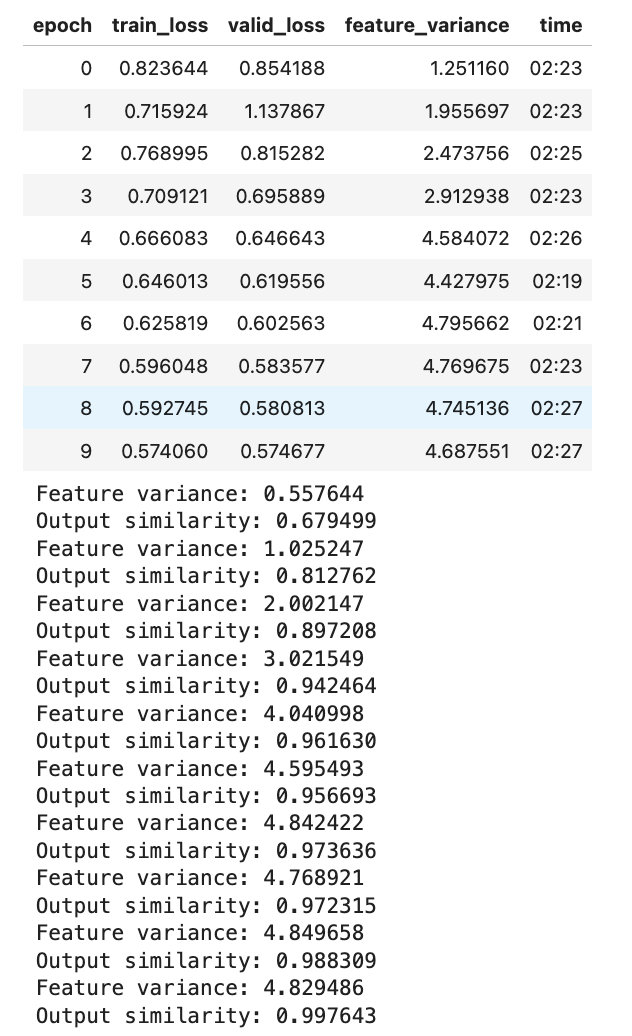

### 7.1 Validation

#### Linear Evaluation

linear evaluation involves freezing the encoder and training a linear classifier on top using labeled data. This is a standard way to assess the quality of learned representations.

```py
class LinearEval(nn.Module):
    def __init__(self, encoder, num_classes=14):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(learn.enc_dim, num_classes)
        
        # Freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        with torch.no_grad():  # Critical for correct evaluation
            features = self.encoder(x)
        return self.classifier(features)

def get_linear_data():
    """Modified DataBlock for labeled Pets"""
    path = untar_data(URLs.PETS)
    files = get_image_files(path/"images")
    pat = r'^(.*)_\d+.jpg$'  # extract pet breed from filename, e.g. "Abyssinian_39.jpg" → "Abyssinian"
    
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=RegexLabeller(pat),
        item_tfms=Resize(32),
        batch_tfms=aug_transforms()  # Standard supervised augs
    ).dataloaders(path/'images', bs=32, num_workers=4)

linear_dls = get_linear_data()

encoder      = deepcopy(learn.model.online_encoder)
linear_model = LinearEval(encoder)

learn_linear = Learner(
    linear_dls,
    linear_model,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    cbs=MixedPrecision()
)

def test_encoder_frozen():
    for param in learn_linear.model.encoder.parameters():
        assert not param.requires_grad

def test_feature_consistency():
    x = torch.randn(4, 3, 32, 32).cuda()
    with torch.no_grad():
        f1 = learn.model.online_encoder(x)
        f2 = learn.model.online_encoder(x)
    assert torch.allclose(f1, f2, atol=1e-6)  # Deterministic features

test_encoder_frozen(), test_feature_consistency()
learn_linear.fit_one_cycle(
    10,
    lr_max=3e-4
)
```





---

## 8. Conclusion

BYOL showcases that self-supervised learning can be effective without contrastive learning. By leveraging **moving target networks, asymmetric predictors, and implicit variance regularization**, BYOL remains a foundational approach for learning powerful image representations.